In [1]:
# zoupet/predictive-analysis-with-different-approaches
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

In [2]:
# Load the data
train = pd.read_csv("../input/train_1.csv")
print train.shape
train.head()

(145063, 551)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# reshape data so that date is a column with visits as the value

In [3]:
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)
print train_flattened.shape
train_flattened.head() 

(7253150, 4)


,Page,date,Visits,weekend
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-12,13.0,1.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-11-12,12.0,1.0
2,3C_zh.wikipedia.org_all-access_spider,2016-11-12,6.0,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-11-12,38.0,1.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-11-12,13.0,1.0


In [62]:
print 'beginning of time'
print train_flattened['date'][0]
print 'end of time'
print train_flattened['date'].tail(1)

beginning of time
2016-11-12 00:00:00
end of time
7253149   2016-12-31
Name: date, dtype: datetime64[ns]


In [4]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [5]:
train_flattened.reset_index(drop=False,inplace=True)
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())
# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,2,2016,11,16


This part allowed us to prepare our data. We had created new features that we use in the next steps. Days, Months, Years are interesting to forecast with a Machine Learning Approach or to do an analysis. If you have another idea to improve this first part: Fork this notebook and improve it or share your idea in the comments.

# II. Aggregation & Visualisation

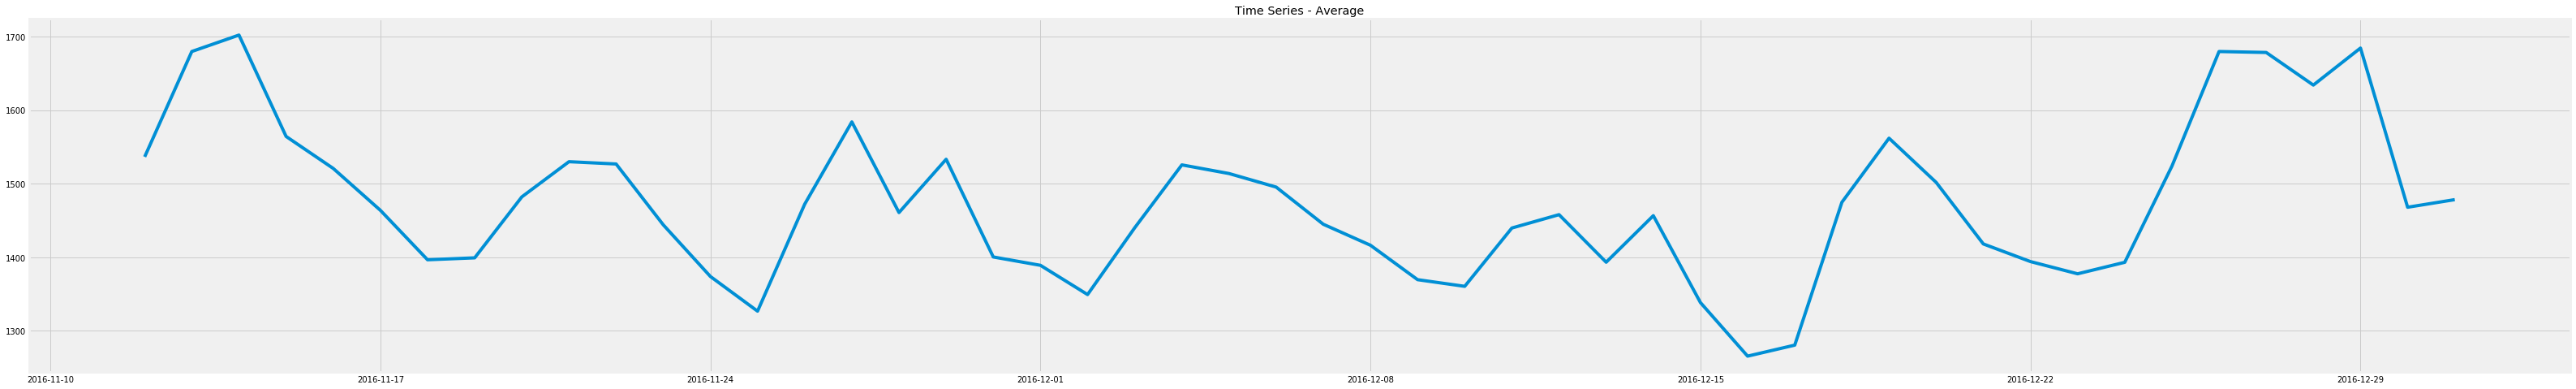

In [6]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

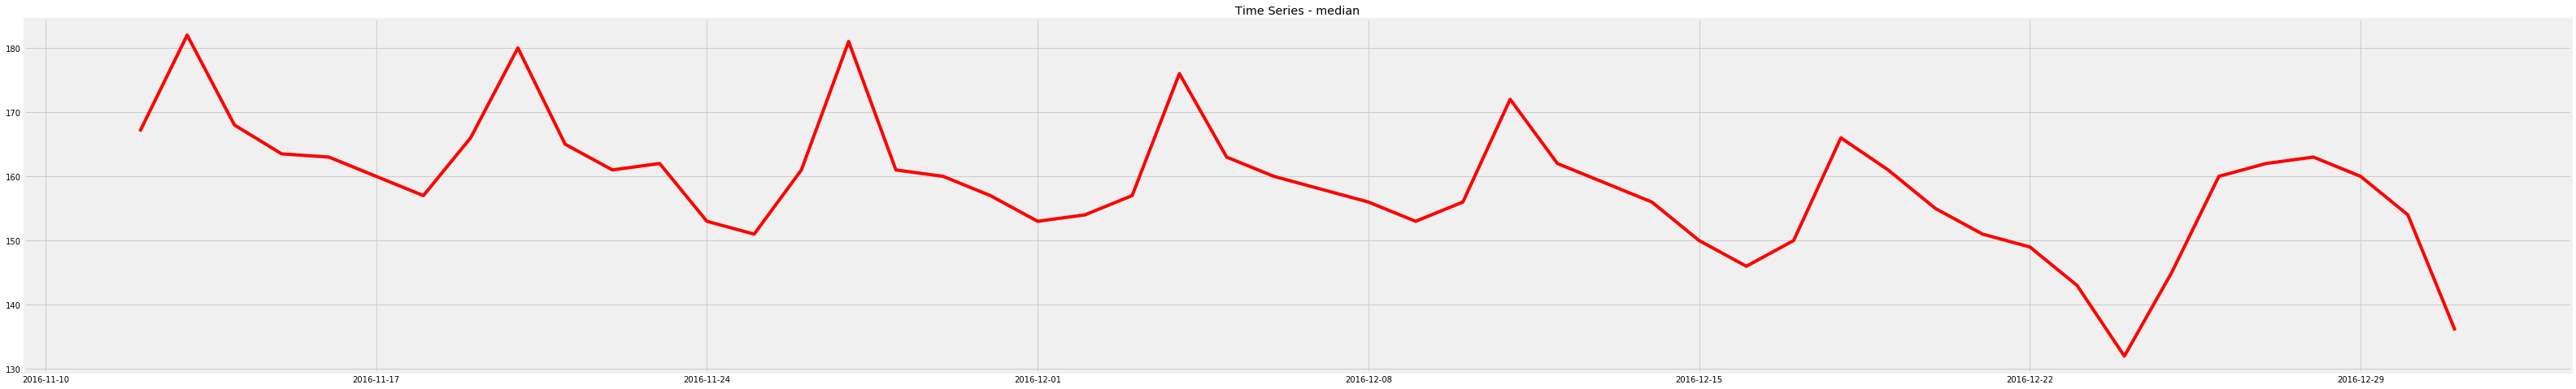

In [7]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

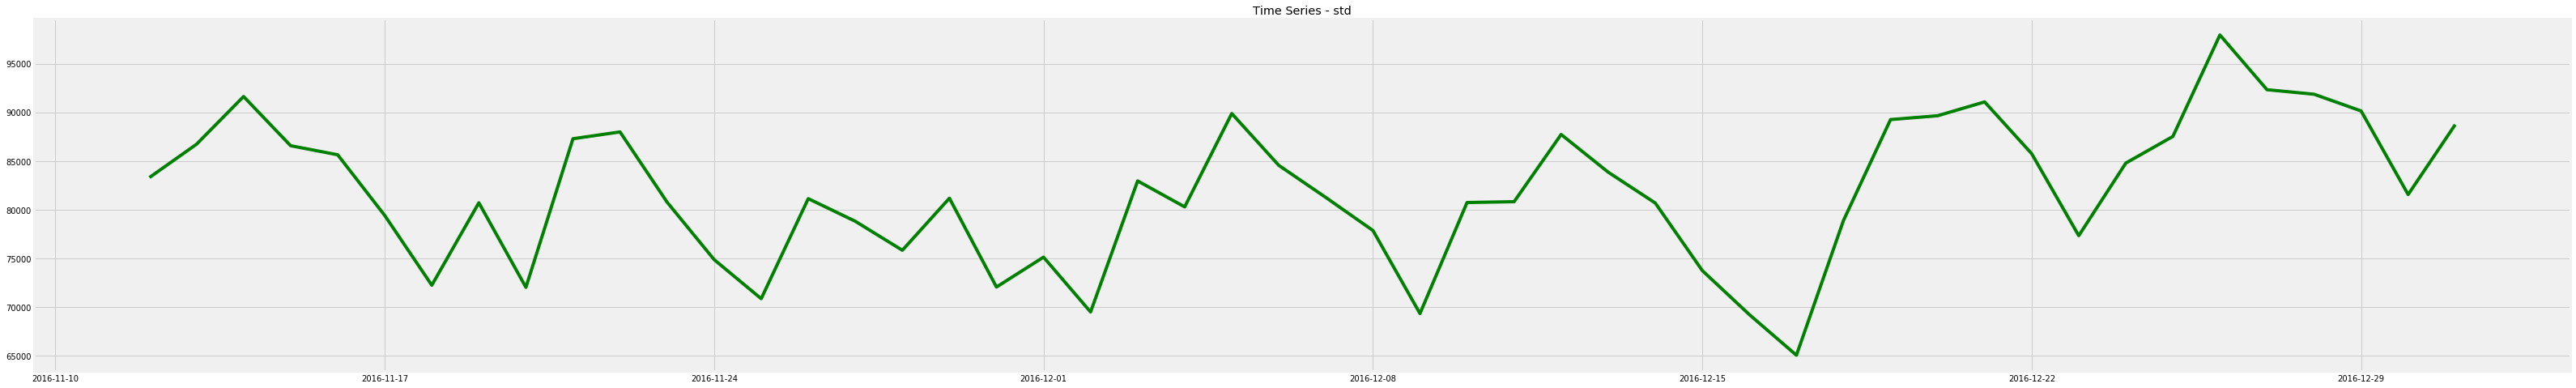

In [8]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [9]:
# For the next graphics
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

In [10]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)
print train_group.shape
print 'web traffic months across weekdays'
train_group.style.background_gradient(cmap='summer_r')

(7, 2)
web traffic months across weekdays


month,11,12
weekday,,
01 - Monday,1564.06,1553.22
02 - Tuesday,1541.32,1517.17
03 - Wednesday,1454.99,1488.31
04 - Thursday,1418.77,1444.47
05 - Friday,1361.63,1365.96
06 - Saturday,1469.24,1390.49
07 - Sunday,1581.81,1490.86


In [11]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot('day','month','Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

train_day.style.background_gradient(cmap='summer_r')

month,11,12
day,,
12,1536.47,1457.88
13,1679.63,1393.22
14,1701.94,1456.5
15,1564.17,1338.36
16,1520.67,1265.57
17,1463.75,1280.52
18,1396.54,1474.68
19,1399.17,1561.79
20,1482.02,1501.7


This heatmap show us in average the web traffic by weekdays cross the months. In our data we can see there are less activity in Friday and Saturday for December and November. And the biggest traffic is on the period Monday - Wednesday. It is possible to do Statistics Test to check if our intuition is ok. But You have a lot of works !

With this graph it is possible to see they are two periods with a bigger activity than the rest. The two periods are 25-29 December and 13-14 November. And we can see one period with little activity 15-17 December. They are maybe few outliers during these two periods. You must to investigate more. (coming soon...)

# III. ML Approach

The first approach introduces is the Machine Learnin Approach. We will use just a AdaBoostRegressor but you can try with other models if you want to find the best model. I tried with a linear model as like Ridge but ADA model is better. I will be interesting to check if GB or XGB can bit ADA. It is possible to do a Neural Network approach too. But this approach will be done if the kagglers want more !!

In [12]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()

,date,Visits,weekday,year,month,day
0,2016-11-12,1536.471757,5,2016,11,12
1,2016-11-13,1679.630589,6,2016,11,13
2,2016-11-14,1701.941831,0,2016,11,14
3,2016-11-15,1564.172228,1,2016,11,15
4,2016-11-16,1520.673959,2,2016,11,16


The first step for the ML approach is to create the feature that we will predict. In our example we don't predict the number of visits but the difference between two days. The tips to create few features is to take the difference between two days and to do a lag. Here we will take a lag of "diff" seven times. If you have a weekly pattern it is an interesting choice. Here we have few data (2 months so 30 values) and it is a contraint. I done some test and the number 7 is a good choice (weekly pattern?).

In [13]:
times_series_means.reset_index(drop=True,inplace=True)

def lag_func(data,lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.ix[1:, "diff"] = (data.iloc[1:, 1].as_matrix() - data.iloc[:len(data)-1, 1].as_matrix())
    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count,lag)
last_date = lagged['date'].max()

In [14]:
#after 7 days works
# make features from the previous day
lagged.head(20)

,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-11-12,1536.471757,5,2016,11,12,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2016-11-13,1679.630589,6,2016,11,13,143.158833,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2016-11-14,1701.941831,0,2016,11,14,22.311241,143.158833,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
3,2016-11-15,1564.172228,1,2016,11,15,-137.769602,22.311241,143.158833,NaN,0.000000,0.000000,0.000000,0.000000
4,2016-11-16,1520.673959,2,2016,11,16,-43.498270,-137.769602,22.311241,143.158833,NaN,0.000000,0.000000,0.000000
5,2016-11-17,1463.751937,3,2016,11,17,-56.922022,-43.498270,-137.769602,22.311241,143.158833,NaN,0.000000,0.000000
6,2016-11-18,1396.544145,4,2016,11,18,-67.207791,-56.922022,-43.498270,-137.769602,22.311241,143.158833,NaN,0.000000
7,2016-11-19,1399.170412,5,2016,11,19,2.626266,-67.207791,-56.922022,-43.498270,-137.769602,22.311241,143.158833,NaN
8,2016-11-20,1482.018739,6,2016,11,20,82.848327,2.626266,-67.207791,-56.922022,-43.498270,-137.769602,22.311241,143.158833
9,2016-11-21,1529.844585,0,2016,11,21,47.825846,82.848327,2.626266,-67.207791,-56.922022,-43.498270,-137.769602,22.311241


In [15]:
# Train Test split
def train_test(data_lag):
    # ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'weekday', 'day']
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

# xtrain is indexes from 8 to 36 because the lag nulls stop at 7
# xt is the complete set from 8 to 49 indexes
# y_train is indexes 37 to 49
# the features for x_train are literally the lag values and weekday and day

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

In [16]:
# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Modelisation with all product
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.as_matrix(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    # Model with all data
    model1.fit(xt, yt) 
    
    return model1, prediction, model0

model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

clr, prediction, clr0  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

-----------------------------------------------
('mae with 70% of the data to train:', 77.19244965544415)
-----------------------------------------------


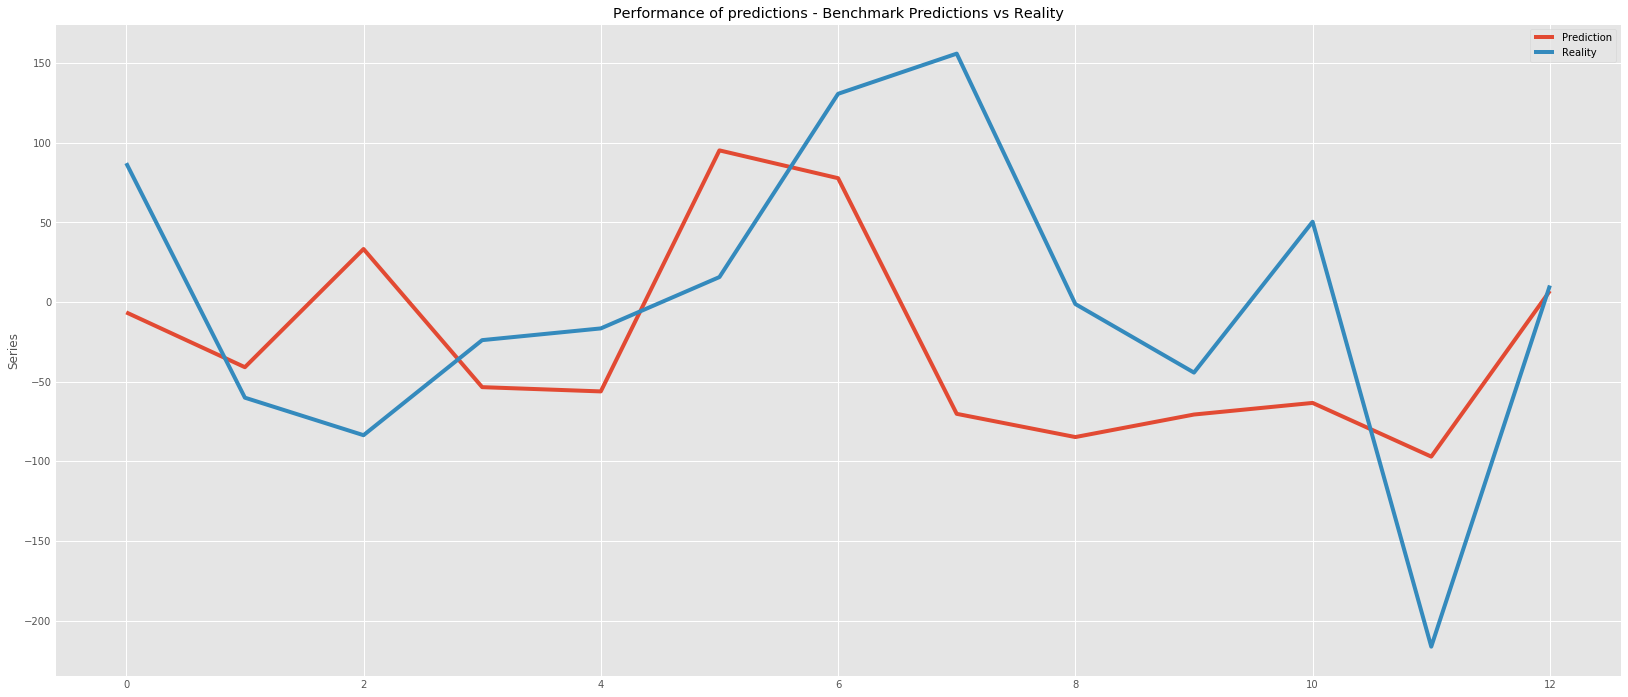

In [17]:
# Performance 1

plt.style.use('ggplot')
plt.figure(figsize=(25, 12))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

# red is prediction / blue is reality

In [18]:
# Prediction
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)

# because the training set ends at december 30 create df for the month of january to predict on

In [19]:
print data_to_pred.head()
print data_to_pred.tail()

        date
0 2017-01-01
1 2017-01-02
2 2017-01-03
3 2017-01-04
4 2017-01-05
         date
26 2017-01-27
27 2017-01-28
28 2017-01-29
29 2017-01-30
30 2017-01-31


In [20]:
lagged.tail(1)

,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
49,2016-12-31,1478.282137,5,2016,12,31,10.338759,-216.364339,50.342112,-44.336265,-1.304683,155.866632,130.640714,15.61749


In [21]:
lagged.tail(1)["diff"].values[0]

10.338759204343887

In [22]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    # Initialisation
    model.fit(xtrain, ytrain)
    
    # take last row of known lagged row to offset lag see above
    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]
        
        data_pred['weekday'] = data_pred['date'].apply(lambda x:x.weekday())
        weekday = data_pred['weekday'][0]
        
        row = pd.Series([lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,weekday]
                        ,['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        #print row
        to_predict = pd.DataFrame(columns = ['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        prediction = pd.DataFrame(columns = ['diff'])
        to_predict = to_predict.append([row])
        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff'])
        
        print to_predict
        print prediction
        
        try:
            print data_pred["date"][i]
            print '\n'
        except:
            pass

        # Loop add lag values to the initial prediction
        if i == 0:
            
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]

        if i > 0 :
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]
        
        data_lag = pd.concat([data_lag,prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["Visits"][data_lag.shape[0]-1] = last_predict
        
        # test
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)
        
    return data_lag

model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

In [23]:
lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)

        lag1        lag2       lag3       lag4      lag5        lag6  \
0  10.338759 -216.364339  50.342112 -44.336265 -1.304683  155.866632   

         lag7      lag8  weekday  
0  130.640714  15.61749      6.0  
       diff
0  79.25221
2017-01-01 00:00:00


       lag1       lag2        lag3       lag4       lag5      lag6  \
0  79.25221  10.338759 -216.364339  50.342112 -44.336265 -1.304683   

         lag7        lag8  weekday  
0  155.866632  130.640714      0.0  
        diff
0  88.612496
2017-01-03 00:00:00


        lag1      lag2       lag3        lag4       lag5       lag6      lag7  \
0  88.612496  79.25221  10.338759 -216.364339  50.342112 -44.336265 -1.304683   

         lag8  weekday  
0  155.866632      1.0  
       diff
0 -2.799872
2017-01-05 00:00:00


       lag1       lag2      lag3       lag4        lag5       lag6       lag7  \
0 -2.799872  88.612496  79.25221  10.338759 -216.364339  50.342112 -44.336265   

       lag8  weekday  
0 -1.304683      2.0  
        

In [35]:
lagged[lagged.date>'2016-12-31'] # as you can see the lags are added as features from the previous one then predicted on and appended to the next set

,Visits,date,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,month,weekday,year
50,1557.534347,2017-01-01,NaN,79.252210,10.338759,-216.364339,50.342112,-44.336265,-1.304683,155.866632,130.640714,15.617490,NaN,6.0,NaN
51,1646.146842,2017-01-02,NaN,88.612496,79.252210,10.338759,-216.364339,50.342112,-44.336265,-1.304683,155.866632,130.640714,NaN,0.0,NaN
52,1643.346971,2017-01-03,NaN,-2.799872,88.612496,79.252210,10.338759,-216.364339,50.342112,-44.336265,-1.304683,155.866632,NaN,1.0,NaN
53,1594.513421,2017-01-04,NaN,-48.833549,-2.799872,88.612496,79.252210,10.338759,-216.364339,50.342112,-44.336265,-1.304683,NaN,2.0,NaN
54,1576.127944,2017-01-05,NaN,-18.385477,-48.833549,-2.799872,88.612496,79.252210,10.338759,-216.364339,50.342112,-44.336265,NaN,3.0,NaN
55,1550.730360,2017-01-06,NaN,-25.397584,-18.385477,-48.833549,-2.799872,88.612496,79.252210,10.338759,-216.364339,50.342112,NaN,4.0,NaN
56,1560.217095,2017-01-07,NaN,9.486735,-25.397584,-18.385477,-48.833549,-2.799872,88.612496,79.252210,10.338759,-216.364339,NaN,5.0,NaN
57,1626.955668,2017-01-08,NaN,66.738573,9.486735,-25.397584,-18.385477,-48.833549,-2.799872,88.612496,79.252210,10.338759,NaN,6.0,NaN
58,1709.803995,2017-01-09,NaN,82.848327,66.738573,9.486735,-25.397584,-18.385477,-48.833549,-2.799872,88.612496,79.252210,NaN,0.0,NaN
59,1706.618893,2017-01-10,NaN,-3.185102,82.848327,66.738573,9.486735,-25.397584,-18.385477,-48.833549,-2.799872,88.612496,NaN,1.0,NaN


In [25]:
lagged[lagged['diff']<0]
lagged.ix[(lagged.Visits < 0), 'Visits'] = 0

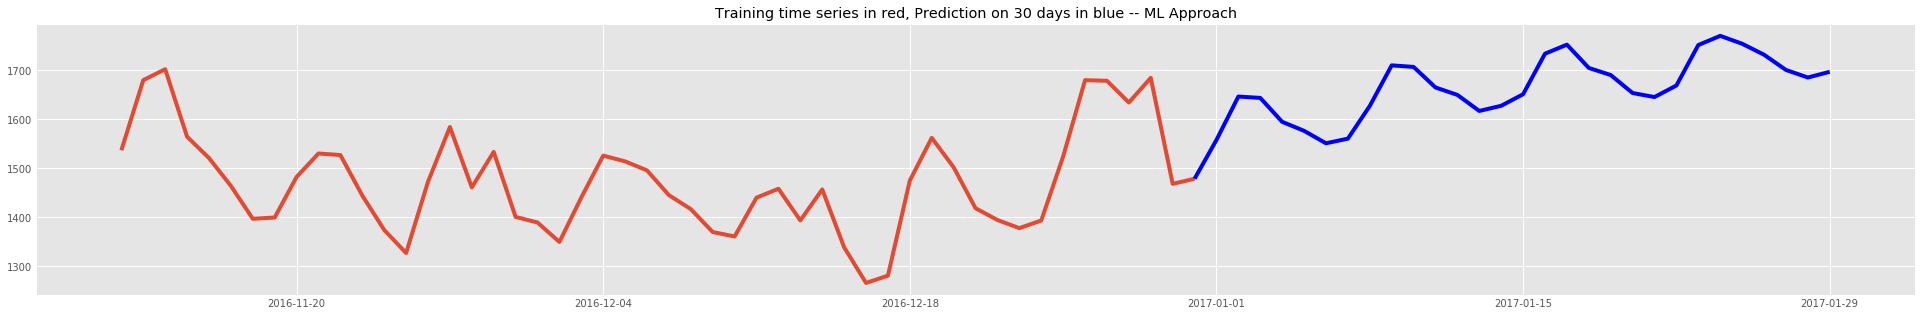

In [26]:
df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()

## end of machine learning approach
Finshed for the first approach ! The ML method requires a lot of work ! You need to create the features, the data to collect the prediction, optimisation etc... This method done a good results when there are a weekly pattern identified or a monthly pattern but we need more data.

# IV. Basic Approach
For this model We will use a simple model with the average of the activity by weekdays. In general rules the simplest things give good results !

In [27]:
lagged_basic = lagged[['date','Visits','weekday']]
lagged_basic_tr   = lagged_basic[lagged_basic['date'] < last_date]
lagged_basic_pred = lagged_basic[lagged_basic['date'] >= last_date]
lagged_basic_pred.drop('Visits',inplace=True,axis=1)

In [28]:
prediction_by_days = pd.DataFrame(lagged_basic.groupby(['weekday'])['Visits'].mean())
prediction_by_days.reset_index(drop=False,inplace=True)
prediction_by_days

,weekday,Visits
0,0.0,1613.317878
1,1.0,1596.790788
2,2.0,1548.737929
3,3.0,1518.802011
4,4.0,1461.298652
5,5.0,1489.810459
6,6.0,1575.831684


In [29]:
basic_pred = pd.merge(lagged_basic_pred,prediction_by_days,on='weekday')
basic_approach = pd.concat([lagged_basic_tr,basic_pred])

In [30]:
plot_basic = np.array(basic_approach[basic_approach['date'] > last_date].sort_values(by='date').Visits)

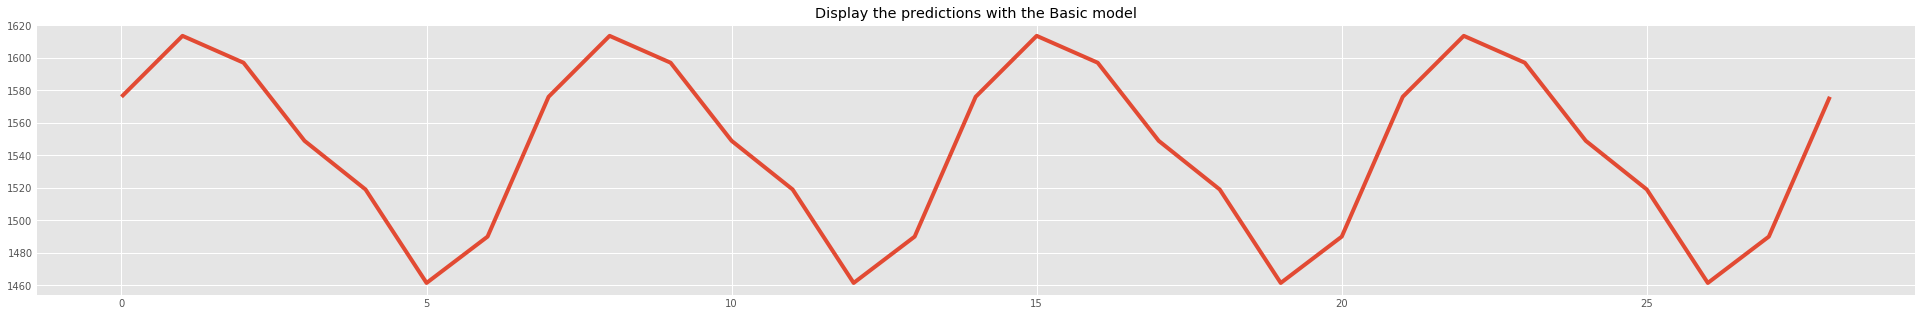

In [31]:
plt.figure(figsize=(30, 5))
plt.plot(plot_basic)
plt.title('Display the predictions with the Basic model')
plt.show()

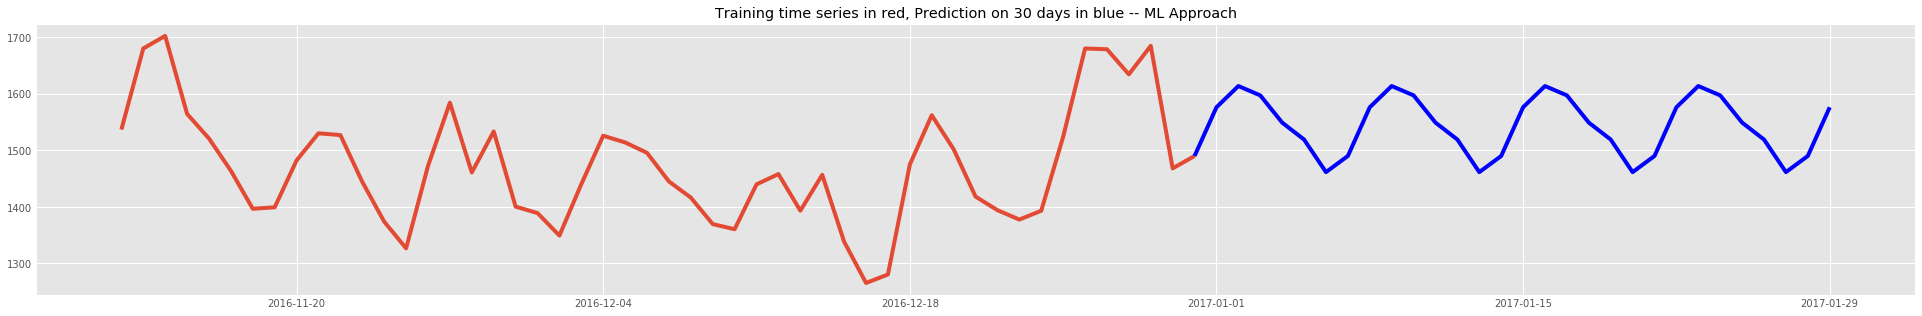

In [32]:
df_lagged = basic_approach[['Visits','date']].sort_values(by='date')
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()
    

# V. ARIMA
This part is inspired by: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/ Very goodjob with the ARIMA models ! It is more simple when we have directly a stationary Time series. It is not our case...

We will use the Dickey-Fuller Test. More informations here: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test

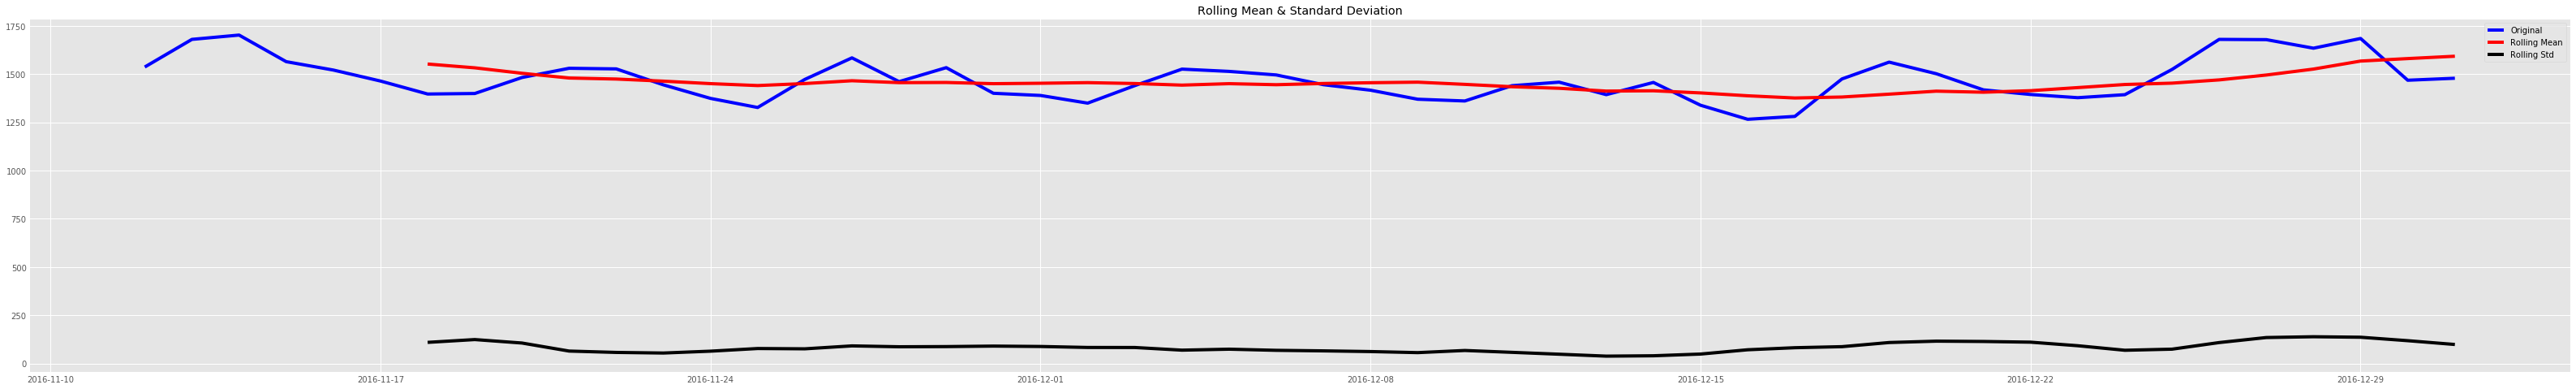

Results of Dickey-Fuller Test:
Test Statistic                 -4.292839
p-value                         0.000457
#Lags Used                      1.000000
Number of Observations Used    48.000000
Critical Value (5%)            -2.923954
Critical Value (1%)            -3.574589
Critical Value (10%)           -2.600039
dtype: float64


In [48]:
import pandas as pd
# Show Rolling mean, Rolling Std and Test for the stationnarity
df_date_index = times_series_means[['date','Visits']].set_index('date')

def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=7)
    #rolstd = pd.rolling_std(timeseries, window=7)
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index['Visits'])   

Our Time Series is stationary ! it is a good news ! We can to apply the ARIMA Model without transformations.

Good job ! We have a Time Series Stationary ! We can apply our ARIMA Model !!!

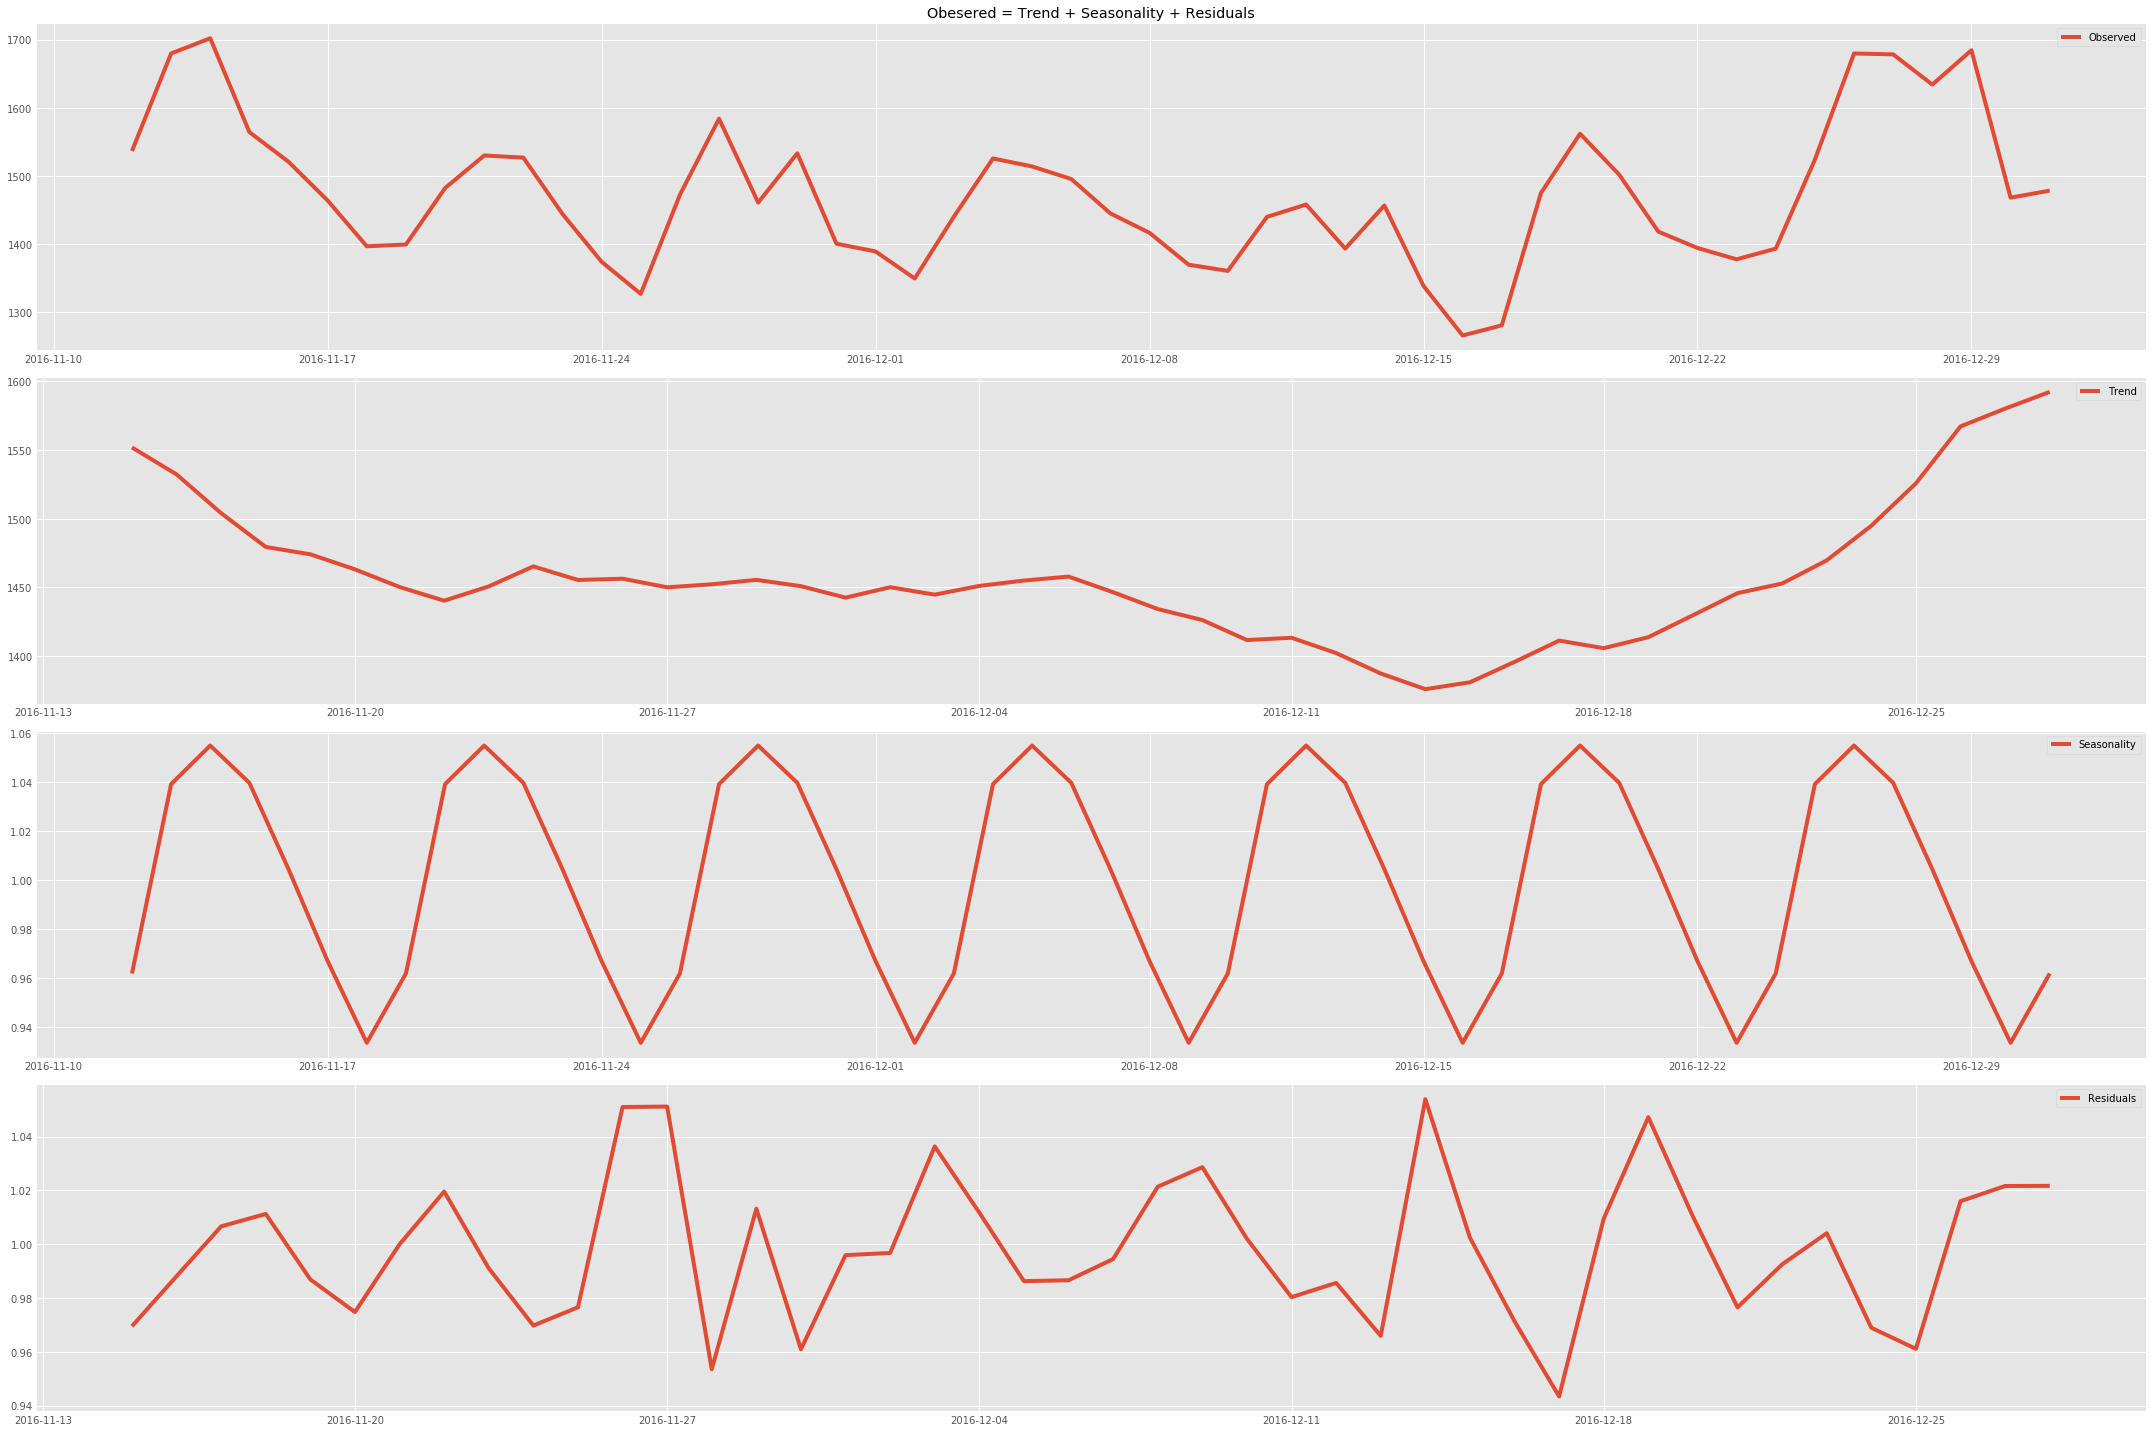

In [49]:
# Naive decomposition of our Time Series as explained above
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 30, 20

plt.subplot(411)
plt.title('Obesered = Trend + Seasonality + Residuals')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We expose the naive decomposition of our time series (More sophisticated methods should be preferred). They are several ways to decompose a time series but in our example we take a simple decomposition on three parts. The additive model is Y[t] = T[t] + S[t] + e[t] The multiplicative model is Y[t] = T[t] x S[t] x e[t] with:

- T[t]: Trend
- S[t]: Seasonality
- e[t]: Residual

An additive model is linear where changes over time are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles). A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line.A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time. In ou example we can see it is not a linear model. So it is the reason why we use a multiplicative model.

# VI. Prophet

Prophet is a forecasting tool availaible in python and R. This tool was created by Facebook. More information on the library here: https://research.fb.com/prophet-forecasting-at-scale/

Compared to the two methods this one will be faster. We can forecast a time series with few lines. In our case we will do a forecast and a display the trend of activity on the period and for a week.

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


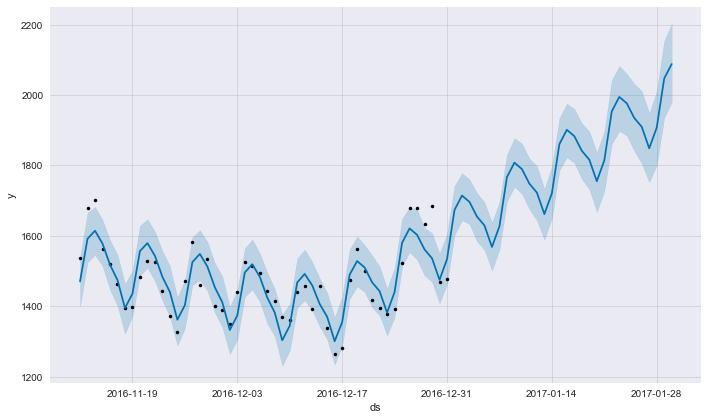

In [51]:
from fbprophet import Prophet
sns.set(font_scale=1) 
df_date_index = times_series_means[['date','Visits']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)

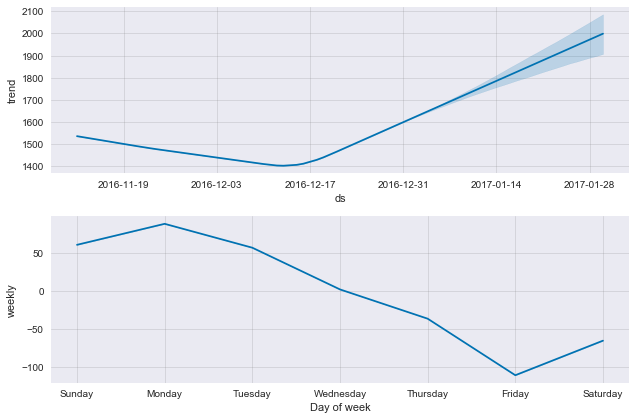

In [52]:
m.plot_components(forecast);


# VI. Keras Starter
In this part we will use Keras without optimisation to forecast. It is just a very simple code to begin with Keras and a Time Series. For our example we will try just with one layer and 8 Neurons.

In [63]:
df_dl = times_series_means[['date','Visits']]

train_size = int(len(df_dl) * 0.80)
test_size = len(df_dl) - train_size
train, test = df_dl.iloc[0:train_size,:], df_dl.iloc[train_size:len(df_dl),:]
print(len(train), len(test))


look_back = 1

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1].values[0]
        b = dataset.iloc[i+look_back, 1]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)

(40, 10)


In [64]:
from keras.models import Sequential
from keras.layers import Dense

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=150, batch_size=2, verbose=0)

Using TensorFlow backend.
/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/tensor_util.py:480: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


In [65]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore, trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (testScore, testScore))

Train Score: 65.86 MSE (65.86 MAE)
Test Score: 81.77 MSE (81.77 MAE)


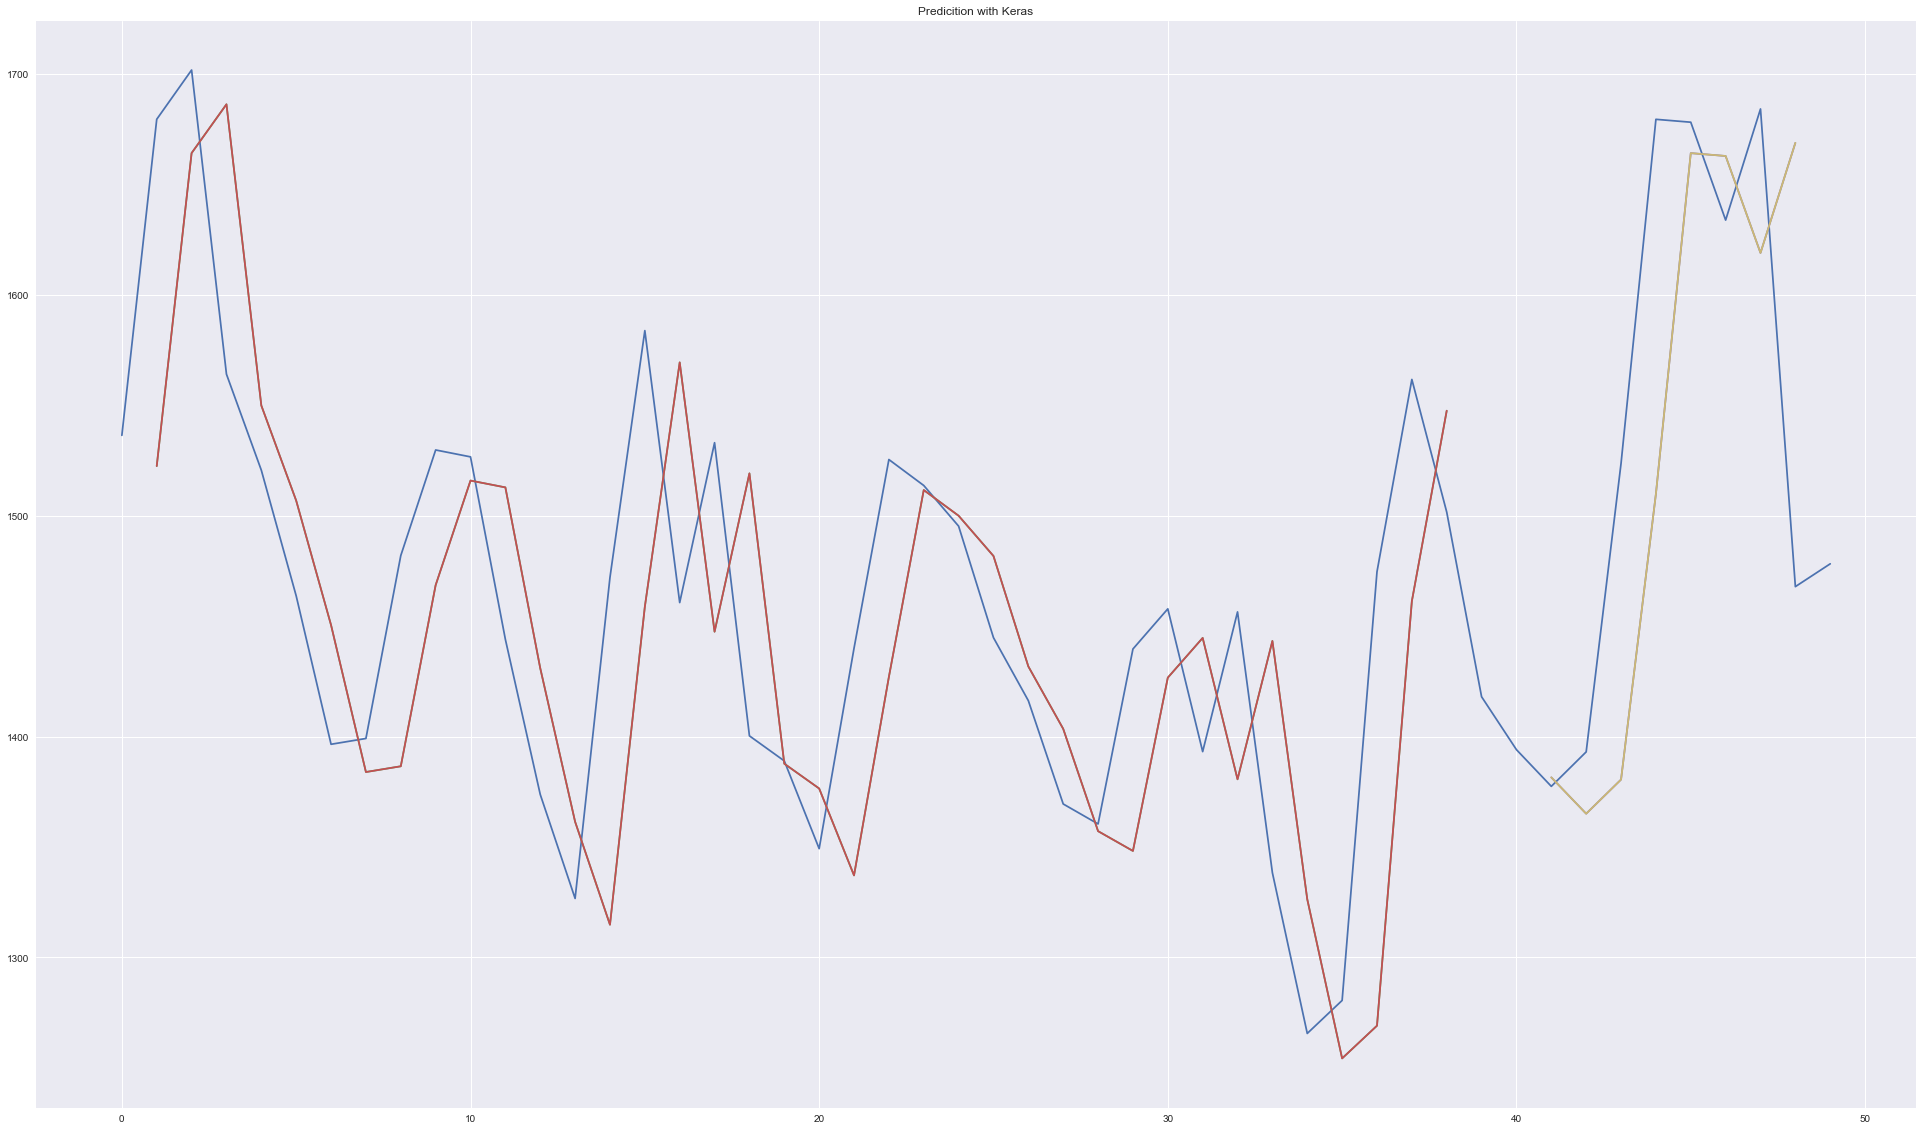

In [66]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_dl)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_dl)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_dl)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(np.array(df_dl.Visits))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Predicition with Keras')
plt.show()